# Introduction to bioinformatics - project no. 2
## CpG islands and DNA Methylation analysis

## Necessary libraries

In [30]:
import pandas as pd
import copy
import time

## Data load

In [31]:
cpg_islands = pd.read_csv("data/cpgIslandExt.txt", sep='\t', header=None)
dna_methylation = pd.read_csv("data/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed", sep='\t', header=None)
chromosomes_sizes = pd.read_csv("data/hg19.chrom.sizes.txt", sep='\t', header=None)

## Data preprocessing

In [32]:
dna_methylation = dna_methylation.loc[:,0:2]
dna_methylation.columns = ["chr_nr", "start", "stop"]
dna_methylation['location'] = ((dna_methylation['stop']-dna_methylation['start'])/2 +
                            dna_methylation['start']).astype('int32')

chromosomes_sizes.columns = ['chr_nr', 'size']
chromosomes_sizes.set_index('chr_nr', inplace=True)

cpg_islands = cpg_islands.loc[:, 1:3]
cpg_islands.columns = ['chr_nr', 'start', 'stop']

## Data exploration

In [4]:
dna_methylation.shape

(482421, 4)

In [5]:
dna_methylation.head()

,chr_nr,start,stop,location
0,chr16,53468112,53468162,53468137
1,chr3,37459206,37459256,37459231
2,chr3,171916037,171916087,171916062
3,chr1,91194674,91194724,91194699
4,chr8,42263294,42263344,42263319


In [6]:
dna_methylation.chr_nr.unique()

array(['chr16', 'chr3', 'chr1', 'chr8', 'chr14', 'chr15', 'chr9', 'chr19',
       'chr6', 'chr12', 'chr2', 'chr4', 'chr11', 'chr20', 'chr10',
       'chr18', 'chr21', 'chr17', 'chr7', 'chr22', 'chrX', 'chr13',
       'chr5', 'chrY'], dtype=object)

In [7]:
cpg_islands.shape

(28691, 3)

In [8]:
cpg_islands.head()

,chr_nr,start,stop
0,chr1,28735,29810
1,chr1,135124,135563
2,chr1,327790,328229
3,chr1,437151,438164
4,chr1,449273,450544


In [9]:
chromosomes_sizes.shape

(93, 1)

In [10]:
chromosomes_sizes.head()

,size
chr_nr,
chr1,249250621
chr2,243199373
chr3,198022430
chr4,191154276
chr5,180915260


## Functions

In [11]:
# states
island = 3
shore = 2
shelve = 1
sea  = 0

def set_point_label(vector, index, new_state):
    """
    tries to set new state of a gene - shore, shelve,
    """
    if(max(new_state, vector[index]) == new_state):
        vector[index] = new_state

In [12]:
def get_list_bounded_range(max_len, start_index, stop_index):
    if(start_index < 0):
        start_index = 0
    if(stop_index > max_len):
        stop_index = max_len
    return range(start_index, stop_index)

In [13]:
def set_range_label(vector, start_index, stop_index, new_state):
    for i in get_list_bounded_range(len(vector), start_index, stop_index):
        set_point_label(vector, i, new_state)

In [14]:
def set_island_states(vector, cpg_island_range):
    diff = 10 # do zmiany
    # left side
    set_range_label(vector, cpg_island_range[0]-2*diff, cpg_island_range[0]-diff, shelve)
    set_range_label(vector, cpg_island_range[0]-diff, cpg_island_range[0], shore)
    
    # island
    set_range_label(vector, cpg_island_range[0], cpg_island_range[1], island)
    
    # right side
    set_range_label(vector, cpg_island_range[1], cpg_island_range[1]+diff, shore)
    set_range_label(vector, cpg_island_range[1]+diff, cpg_island_range[1]+2*diff, shelve)

In [15]:
def vec_states2df(df_list, chr_nr, states_vec):
    starts = [None]*5
    for i in range(1,len(states_vec)):
        if(states_vec[i] - states_vec[i-1] == 0):
            continue
        elif(states_vec[i] - states_vec[i-1] > 0):
            starts[states_vec[i]] = i
        elif(states_vec[i] - states_vec[i-1] < 0):
            # dodaj do df states_vec[i-1] od starts[tego] do i-1, wyzeruj starts
            df_list[states_vec[i-1]].loc[df_list[states_vec[i-1]].shape[0]+1] = [chr_nr, starts[states_vec[i-1]], i-1]
            starts[states_vec[i-1]] = None
    # considering last element of states_vec
    for state, start in enumerate(starts):
        if(start is not None):
            df_list[state].loc[df_list[state].shape[0]+1] = [chr_nr, start, len(states_vec)]
            start = None

In [16]:
chromosomes = [('chr' + str(i)) for i in range(1, 23)]
islands = pd.DataFrame(columns = ['chr_nr', 'start', 'stop'])
shores = pd.DataFrame(columns = ['chr_nr', 'start', 'stop'])
shelves = pd.DataFrame(columns = ['chr_nr', 'start', 'stop'])
seas = pd.DataFrame(columns = ['chr_nr', 'start', 'stop'])
df_list = [seas, shelves, shores, islands]

print(time.asctime(time.localtime(time.time())))
for i in chromosomes:
    print(i, time.asctime(time.localtime(time.time())))
    states_vec = [0] * chromosomes_sizes['size'][i]
    cpg_islands_i = cpg_islands[cpg_islands.chr_nr == i]
    print("cpg_islands_i.shape", cpg_islands_i.shape)
    for j in range(cpg_islands_i.shape[0]):
        diff = 2000 #do zmiany
        cpg_island_range = list(cpg_islands.iloc[j][1:3])
        set_island_states(states_vec, cpg_island_range)
    #locate states
    print(states_vec)
    vec_states2df(df_list, i, states_vec)
print("end", time.asctime(time.localtime(time.time())))

Sun Nov 24 13:04:53 2019
chr1 Sun Nov 24 13:04:53 2019
cpg_islands_i.shape (2462, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr2 Sun Nov 24 13:13:26 2019
cpg_islands_i.shape (1688, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr3 Sun Nov 24 13:21:10 2019
cpg_islands_i.shape (1163, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr4 Sun Nov 24 13:27:09 2019
cpg_islands_i.shape (1031, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr5 Sun Nov 24 13:32:20 2019
cpg_islands_i.shape (1229, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr6 Sun Nov 24 13:38:41 2019
cpg_islands_i.shape (1253, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr7 Sun Nov 24 13:44:40 2019
cpg_islands_i.shape (1578, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr8 Sun Nov 24 13:48:19 2019
cpg_islands_i.shape (1037, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr9 Sun Nov 24 13:50:55 2019
cpg_islands_i.shape (1226, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr10 Sun Nov 24 13:53:13 2019
cpg_islands_i.shape (1143, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr11 Sun Nov 24 13:54:46 2019
cpg_islands_i.shape (1367, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr12 Sun Nov 24 13:56:17 2019
cpg_islands_i.shape (1221, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr13 Sun Nov 24 13:57:55 2019
cpg_islands_i.shape (605, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr14 Sun Nov 24 13:58:53 2019
cpg_islands_i.shape (788, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr15 Sun Nov 24 13:59:38 2019
cpg_islands_i.shape (792, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr16 Sun Nov 24 14:00:22 2019
cpg_islands_i.shape (1491, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr17 Sun Nov 24 14:01:11 2019
cpg_islands_i.shape (1634, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr18 Sun Nov 24 14:01:59 2019
cpg_islands_i.shape (507, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr19 Sun Nov 24 14:02:29 2019
cpg_islands_i.shape (2541, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr20 Sun Nov 24 14:03:13 2019
cpg_islands_i.shape (801, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr21 Sun Nov 24 14:03:47 2019
cpg_islands_i.shape (365, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



chr22 Sun Nov 24 14:04:08 2019
cpg_islands_i.shape (719, 3)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



end Sun Nov 24 14:04:39 2019


## Save results

In [17]:
islands.to_csv('islands.csv')
shores.to_csv('shores.csv')
shelves.to_csv('shelves.csv')

## Count DNA methylation on CPG islands

In [33]:
import random
import numpy as np
random.seed(0)
dna_methylation = dna_methylation[dna_methylation.chr_nr.isin(chromosomes)]
print(dna_methylation.shape)
rand_indexes = [random.randint(0, dna_methylation.shape[0]) for i in range(100)]

(470870, 4)


In [34]:
islands_count = 0
shores_count = 0
shelves_count = 0
seas_count = 0

dna_methylation_small = dna_methylation.iloc[np.unique(rand_indexes)]
print('Start:', time.asctime(time.localtime(time.time())))
print('DNA methylation shape:', dna_methylation_small.shape)
for i, met in dna_methylation_small.iterrows():
    shelves_met = shelves[shelves.chr_nr == met.chr_nr]
    islands_met = islands[islands.chr_nr == met.chr_nr]
    shores_met = shores[shores.chr_nr == met.chr_nr]
    is_found = False
    for j, island in islands.iterrows():
        if island.start <= met.location <= island.stop:
            islands_count += 1
            is_found = True
            break
    if is_found is False:
        for j, shore in shores.iterrows():
            if shore.start <= met.location <= shore.stop:
                shores_count += 1
                is_found = True
                break
    if is_found is False:
        for j, shelve in shelves.iterrows():
                if shelve.start <= met.location <= shelve.stop:
                    shelves_count += 1
                    is_found = True
                    break
print('Finished:', time.asctime(time.localtime(time.time())))
seas_count = dna_methylation_small.shape[0] - sum([islands_count, shores_count, shelves_count])
print('')
print(islands_count)
print(shores_count)
print(shelves_count)
print(seas_count)

Start: Sun Nov 24 15:34:06 2019
DNA methylation shape: (100, 4)
Finished: Sun Nov 24 15:53:11 2019

4
1
0
95


## Results plot

In [35]:
import seaborn as sn

In [36]:
plot_data = pd.DataFrame({
    'count_type': ['islands', 'shelves', 'shores'],
    'count':[islands_count, shelves_count, shores_count]
})

In [37]:
plot_data.to_csv('results.csv')

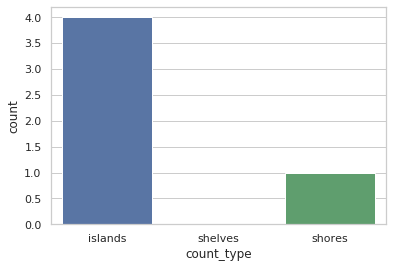

In [44]:
sn.set(style="whitegrid")
sn.barplot(data=plot_data, x='count_type', y='count')